# Goal is to answer the question: can a machine detect a person's gender based on their tweet?

Steps:
1. Get twitter data
2. Clean
3. Analyze and visualize
4. Build model
5. Test model

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import tweepy as tw
import seaborn as sns
import json
import pprint
from matplotlib import pyplot as plt

# Import libraries for WordCloud
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

import spacy
import nltk
from nltk import PorterStemmer
import textblob
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Connect to twitter API
path_auth = '/Users/allenj/Documents/Keys/auth_twitter.json'
auth = json.loads(open(path_auth).read())
pp = pprint.PrettyPrinter(indent=4)

my_consumer_key = auth['my_consumer_key']
my_consumer_secret = auth['my_consumer_secret']
my_access_token = auth['your_access_token']
my_access_token_secret = auth['my_access_token_secret']

auth = tw.OAuthHandler(my_consumer_key, my_consumer_secret)
auth.set_access_token(my_access_token, my_access_token_secret)
api = tw.API(auth)

type(api)

tweepy.api.API

# 1. Get Twitter data

In [3]:
# Upload list of desired users
# Gender 0 = male, 1 = female
users = pd.read_csv('../Data/twitter-users.csv')
users.head(50)

,user,name,gender,followers_millions,activity,country
0,BarackObama,Barack Obama,0,118,Former U.S. president,United States
1,justinbieber,Justin Bieber,0,111,Musician,Canada
2,katyperry,Katy Perry,1,108,Musician,United States
3,rihanna,Rihanna,1,96,Musician and businesswoman,Barbados
4,taylorswift13,Taylor Swift,1,86,Musician,United States
5,Cristiano,Cristiano Ronaldo,0,84,Footballer,Portugal
6,ladygaga,Lady Gaga,1,81,Musician and actress,United States
7,TheEllenShow,Ellen DeGeneres,1,80,Comedian and television hostess,United States
8,ArianaGrande,Ariana Grande,1,74,Musician and actress,United States
9,KimKardashian,Kim Kardashian,1,65,Television personality and businesswoman,United States


In [6]:
# Get collection of tweets from these usernames and store it into a new dataframe
list = []

for index, row in users.iterrows():
    tweets = api.user_timeline(screen_name=row['user'], count=5, include_rts=False)
    users_text = [[tweet.user.screen_name, tweet.text, row['gender']] for tweet in tweets]
    tweet_text = pd.DataFrame(data=users_text, 
                        columns=["user", "text", "gender"])
    list.append(tweet_text)

# Merge the list    
tweets = pd.concat(list) 
tweets

,user,text,gender
0,BarackObama,We’ve seen the power that our voices have when...,0
1,BarackObama,"On National Gun Violence Awareness Day, we #We...",0
2,BarackObama,"Third, every city in this country should be a ...",0
3,BarackObama,"Second, every mayor should review their use of...",0
4,BarackObama,"First, there are specific evidence-based refor...",0
...,...,...,...
0,RyanLochte,#blackouttuesday ✊🏿✊🏾✊🏼✊ https://t.co/msGORMTM9e,0
1,RyanLochte,Tomorrow at 11 am EST I’m going to go on IG Li...,0
2,RyanLochte,Tomorrow at 11 am EST I’m going to go on IG Li...,0
3,RyanLochte,K-swiss and Heal the Bay are dedicated to maki...,0


In [9]:
# Clean the text
nlp = spacy.load('en')

In [30]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [31]:
tweets['clean'] = tweets['text'].apply(clean_text)
tweets

,user,text,gender,clean,clean2
0,BarackObama,We’ve seen the power that our voices have when...,0,We’ve seen the power that our voices have when...,see power voice speak injustice––but know toll...
1,BarackObama,"On National Gun Violence Awareness Day, we #We...",0,"On National Gun Violence Awareness Day, we #We...",national gun violence awareness day WearOrange...
2,BarackObama,"Third, every city in this country should be a ...",0,"Third, every city in this country should be a ...",city country @MBK_Alliance community 250 city ...
3,BarackObama,"Second, every mayor should review their use of...",0,"Second, every mayor should review their use of...",Second mayor review use force policy member co...
4,BarackObama,"First, there are specific evidence-based refor...",0,"First, there are specific evidence-based refor...",specific evidence base reform build trust save...
...,...,...,...,...,...
0,RyanLochte,#blackouttuesday ✊🏿✊🏾✊🏼✊ https://t.co/msGORMTM9e,0,#blackouttuesday ✊🏿✊🏾✊🏼✊ https://t.co/msGORMTM9e,blackouttuesday ✊ 🏿 ✊ 🏾 ✊ 🏼 ✊ https://t.co/msg...
1,RyanLochte,Tomorrow at 11 am EST I’m going to go on IG Li...,0,Tomorrow at 11 am EST I’m going to go on IG Li...,Tomorrow 11 est go ig live guy @spire_institut...
2,RyanLochte,Tomorrow at 11 am EST I’m going to go on IG Li...,0,Tomorrow at 11 am EST I’m going to go on IG Li...,Tomorrow 11 est go ig live guy @spire_institut...
3,RyanLochte,K-swiss and Heal the Bay are dedicated to maki...,0,K-swiss and Heal the Bay are dedicated to maki...,k swiss heal bay dedicated make California coa...


In [15]:
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [20]:
%time
tweets['clean2'] = tweets['clean'].apply(convert_text)
tweets.head(20)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


,user,text,gender,clean,clean2
0,BarackObama,We’ve seen the power that our voices have when...,0,We’ve seen the power that our voices have when...,see power voice speak injustice––but know toll...
1,BarackObama,"On National Gun Violence Awareness Day, we #We...",0,"On National Gun Violence Awareness Day, we #We...",national gun violence awareness day WearOrange...
2,BarackObama,"Third, every city in this country should be a ...",0,"Third, every city in this country should be a ...",city country @MBK_Alliance community 250 city ...
3,BarackObama,"Second, every mayor should review their use of...",0,"Second, every mayor should review their use of...",Second mayor review use force policy member co...
4,BarackObama,"First, there are specific evidence-based refor...",0,"First, there are specific evidence-based refor...",specific evidence base reform build trust save...
0,justinbieber,https://t.co/Ust1E366LK,0,https://t.co/Ust1E366LK,https://t.co/ust1e366lk
1,justinbieber,https://t.co/jLyOzKD3GG,0,https://t.co/jLyOzKD3GG,https://t.co/jlyozkd3gg
2,justinbieber,https://t.co/6rMshM23mu,0,https://t.co/6rMshM23mu,https://t.co/6rmshm23mu
3,justinbieber,Thank you @angela_rye for the conversation,0,Thank you @angela_rye for the conversation,thank @angela_rye conversation
4,justinbieber,Live https://t.co/WUjCacT9ae,0,Live https://t.co/WUjCacT9ae,live https://t.co/wujcact9ae


In [85]:
# Count the number of datapoints per person
tweets.groupby(["user", "gender"]).size()

user            gender
AdamMGrant      0         150
Adele           1         145
AnushkaSharma   1         113
ArianaGrande    1          86
AvrilLavigne    1          93
                         ... 
staceyannchin   1         131
susanmcp1       1          40
taylorswift13   1         142
unhealthytruth  1         111
wizkhalifa      0          66
Length: 84, dtype: int64

# 2. Clean text

### Remove things

In [86]:
tweets['clean_text'] = tweets['text']
tweets

,user,text,gender,clean_text
0,BarackObama,"On National Gun Violence Awareness Day, we #We...",0,"On National Gun Violence Awareness Day, we #We..."
1,BarackObama,"Third, every city in this country should be a ...",0,"Third, every city in this country should be a ..."
2,BarackObama,"Second, every mayor should review their use of...",0,"Second, every mayor should review their use of..."
3,BarackObama,"First, there are specific evidence-based refor...",0,"First, there are specific evidence-based refor..."
4,BarackObama,Real change requires protest to highlight a pr...,0,Real change requires protest to highlight a pr...
...,...,...,...,...
139,RyanLochte,"“Eyez on the Prize” made by the man, top curre...",0,"“Eyez on the Prize” made by the man, top curre..."
140,RyanLochte,Happy birthday to my lil sister @ebeisel34 you...,0,Happy birthday to my lil sister @ebeisel34 you...
141,RyanLochte,The water is my happy place. It gives me oppor...,0,The water is my happy place. It gives me oppor...
142,RyanLochte,The water is my happy place. It gives me oppor...,0,The water is my happy place. It gives me oppor...


In [87]:
# Clean text by removing things
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

#Remove @ symbol, URL links, and "&amp;"
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['text'], "@[\w]*") #removes all @
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "&amp;")
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "#[\w]*") #removes all hashtags
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "https:\/\/.*[\r\n]*")
tweets

,user,text,gender,clean_text
0,BarackObama,"On National Gun Violence Awareness Day, we #We...",0,"On National Gun Violence Awareness Day, we to..."
1,BarackObama,"Third, every city in this country should be a ...",0,"Third, every city in this country should be a ..."
2,BarackObama,"Second, every mayor should review their use of...",0,"Second, every mayor should review their use of..."
3,BarackObama,"First, there are specific evidence-based refor...",0,"First, there are specific evidence-based refor..."
4,BarackObama,Real change requires protest to highlight a pr...,0,Real change requires protest to highlight a pr...
...,...,...,...,...
139,RyanLochte,"“Eyez on the Prize” made by the man, top curre...",0,"“Eyez on the Prize” made by the man, top curre..."
140,RyanLochte,Happy birthday to my lil sister @ebeisel34 you...,0,Happy birthday to my lil sister you seriously...
141,RyanLochte,The water is my happy place. It gives me oppor...,0,The water is my happy place. It gives me oppor...
142,RyanLochte,The water is my happy place. It gives me oppor...,0,The water is my happy place. It gives me oppor...


In [13]:
testset = pd.read_csv('../Data/twitter-test.csv')
testset

,name,gender,text
0,ArianaHuffington,1,But you have to do what you dream of doing eve...
1,JessicaAlba,1,My biggest baby is 11 today! I’m so proud of t...
2,Chamath,0,"Make no mistake, we may be in a terrible place..."
3,BarackObama,0,"It’s World Health Day, and we owe a profound d..."
4,RichardBranson,0,"Tie-loathing adventurer, philanthropist & trou..."
5,MarissaMayer,1,The highlight of my week was seeing season pas...


In [14]:
# Do the same for the testing dataset
# Clean text by removing things
testset['clean_text'] = np.vectorize(remove_pattern)(testset['text'], "@[\w]*") #removes all @
testset['clean_text'] = np.vectorize(remove_pattern)(testset['clean_text'], "https?:\/\/.*[\r\n]*")
testset['clean_text'] = np.vectorize(remove_pattern)(testset['clean_text'], "&amp;")
testset['clean_text'] = np.vectorize(remove_pattern)(testset['clean_text'], "#[\w]*") #removes all hashtags
testset

,name,gender,text,clean_text
0,ArianaHuffington,1,But you have to do what you dream of doing eve...,But you have to do what you dream of doing eve...
1,JessicaAlba,1,My biggest baby is 11 today! I’m so proud of t...,My biggest baby is 11 today! I’m so proud of t...
2,Chamath,0,"Make no mistake, we may be in a terrible place...","Make no mistake, we may be in a terrible place..."
3,BarackObama,0,"It’s World Health Day, and we owe a profound d...","It’s World Health Day, and we owe a profound d..."
4,RichardBranson,0,"Tie-loathing adventurer, philanthropist & trou...","Tie-loathing adventurer, philanthropist & trou..."
5,MarissaMayer,1,The highlight of my week was seeing season pas...,The highlight of my week was seeing season pas...


### Remove punctuations

In [88]:
# Remove punctuation, numbers, and special characters
tweets['clean_text'] = tweets['clean_text'].str.replace("[^a-zA-Z#]", " ")
tweets

,user,text,gender,clean_text
0,BarackObama,"On National Gun Violence Awareness Day, we #We...",0,On National Gun Violence Awareness Day we to...
1,BarackObama,"Third, every city in this country should be a ...",0,Third every city in this country should be a ...
2,BarackObama,"Second, every mayor should review their use of...",0,Second every mayor should review their use of...
3,BarackObama,"First, there are specific evidence-based refor...",0,First there are specific evidence based refor...
4,BarackObama,Real change requires protest to highlight a pr...,0,Real change requires protest to highlight a pr...
...,...,...,...,...
139,RyanLochte,"“Eyez on the Prize” made by the man, top curre...",0,Eyez on the Prize made by the man top curre...
140,RyanLochte,Happy birthday to my lil sister @ebeisel34 you...,0,Happy birthday to my lil sister you seriously...
141,RyanLochte,The water is my happy place. It gives me oppor...,0,The water is my happy place It gives me oppor...
142,RyanLochte,The water is my happy place. It gives me oppor...,0,The water is my happy place It gives me oppor...


In [31]:
# Do the same for the testing dataset
# Remove punctuation, numbers, and special characters
testset['clean_text'] = testset['clean_text'].str.replace("[^a-zA-Z#]", " ")
testset

,name,gender,text,clean_text
0,ArianaHuffington,1,But you have to do what you dream of doing eve...,But you have to do what you dream of doing eve...
1,JessicaAlba,1,My biggest baby is 11 today! I’m so proud of t...,My biggest baby is today I m so proud of t...
2,Chamath,0,"Make no mistake, we may be in a terrible place...",Make no mistake we may be in a terrible place...
3,BarackObama,0,"It’s World Health Day, and we owe a profound d...",It s World Health Day and we owe a profound d...
4,RichardBranson,0,"Tie-loathing adventurer, philanthropist & trou...",Tie loathing adventurer philanthropist trou...
5,MarissaMayer,1,The highlight of my week was seeing season pas...,The highlight of my week was seeing season pas...


### Remove stop words

In [89]:
# Remove short words less than 3
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tweets.head(10)

,user,text,gender,clean_text
0,BarackObama,"On National Gun Violence Awareness Day, we #We...",0,National Violence Awareness honor victims surv...
1,BarackObama,"Third, every city in this country should be a ...",0,Third every city this country should community...
2,BarackObama,"Second, every mayor should review their use of...",0,Second every mayor should review their force p...
3,BarackObama,"First, there are specific evidence-based refor...",0,First there specific evidence based reforms th...
4,BarackObama,Real change requires protest to highlight a pr...,0,Real change requires protest highlight problem...
5,BarackObama,"In our @MBK_Alliance town hall yesterday, I me...",0,town hall yesterday mentioned James Baldwin Fi...
6,BarackObama,"And third, an extraordinary essay by the forme...",0,third extraordinary essay former Chairman Join...
7,BarackObama,"Second, a reminder of the difference politics ...",0,Second reminder difference politics voting mak...
8,BarackObama,Here’s a useful read––a reminder of the import...,0,Here useful read reminder importance escalatio...
9,BarackObama,"""Let’s do this another way. Let's stop thinkin...",0,this another stop thinking voice matter vote j...


In [33]:
# Do the same for the testing dataset
# Remove short words less than 2
testset['clean_text'] = testset['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
testset.head(10)

,name,gender,text,clean_text
0,ArianaHuffington,1,But you have to do what you dream of doing eve...,have what dream doing even while afraid
1,JessicaAlba,1,My biggest baby is 11 today! I’m so proud of t...,biggest baby today proud kind artistic curious...
2,Chamath,0,"Make no mistake, we may be in a terrible place...",Make mistake terrible place right young people...
3,BarackObama,0,"It’s World Health Day, and we owe a profound d...",World Health profound debt gratitude medical p...
4,RichardBranson,0,"Tie-loathing adventurer, philanthropist & trou...",loathing adventurer philanthropist troublemake...
5,MarissaMayer,1,The highlight of my week was seeing season pas...,highlight week seeing season passes Jackson Ho...


### Create new column to count length of clean text

In [90]:
# Count length of characters
tweets['length'] = tweets['clean_text'].apply(len)
tweets

,user,text,gender,clean_text,length
0,BarackObama,"On National Gun Violence Awareness Day, we #We...",0,National Violence Awareness honor victims surv...,66
1,BarackObama,"Third, every city in this country should be a ...",0,Third every city this country should community...,74
2,BarackObama,"Second, every mayor should review their use of...",0,Second every mayor should review their force p...,96
3,BarackObama,"First, there are specific evidence-based refor...",0,First there specific evidence based reforms th...,96
4,BarackObama,Real change requires protest to highlight a pr...,0,Real change requires protest highlight problem...,90
...,...,...,...,...,...
139,RyanLochte,"“Eyez on the Prize” made by the man, top curre...",0,Eyez Prize made currency artist transparentart...,76
140,RyanLochte,Happy birthday to my lil sister @ebeisel34 you...,0,Happy birthday sister seriously bring smile ev...,57
141,RyanLochte,The water is my happy place. It gives me oppor...,0,water happy place gives opportunity clear head...,58
142,RyanLochte,The water is my happy place. It gives me oppor...,0,water happy place gives opportunity clear head...,58


In [35]:
# Do the same for the testing dataset
# Count length
testset['length'] = testset['clean_text'].apply(len)
testset

,name,gender,text,clean_text,length
0,ArianaHuffington,1,But you have to do what you dream of doing eve...,have what dream doing even while afraid,39
1,JessicaAlba,1,My biggest baby is 11 today! I’m so proud of t...,biggest baby today proud kind artistic curious...,139
2,Chamath,0,"Make no mistake, we may be in a terrible place...",Make mistake terrible place right young people...,102
3,BarackObama,0,"It’s World Health Day, and we owe a profound d...",World Health profound debt gratitude medical p...,156
4,RichardBranson,0,"Tie-loathing adventurer, philanthropist & trou...",loathing adventurer philanthropist troublemake...,83
5,MarissaMayer,1,The highlight of my week was seeing season pas...,highlight week seeing season passes Jackson Ho...,141


### Remove rows in training data that have less than desired text length

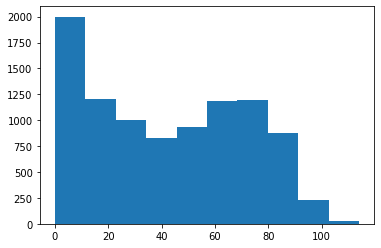

In [91]:
plt.hist(tweets['length'])
plt.show()

In [92]:
tweets['length'].describe()

count    9473.000000
mean       42.015518
std        29.385760
min         0.000000
25%        15.000000
50%        41.000000
75%        68.000000
max       114.000000
Name: length, dtype: float64

In [93]:
# Remove rows where length <= 30
tweets = tweets[tweets.length > 30]
tweets

,user,text,gender,clean_text,length
0,BarackObama,"On National Gun Violence Awareness Day, we #We...",0,National Violence Awareness honor victims surv...,66
1,BarackObama,"Third, every city in this country should be a ...",0,Third every city this country should community...,74
2,BarackObama,"Second, every mayor should review their use of...",0,Second every mayor should review their force p...,96
3,BarackObama,"First, there are specific evidence-based refor...",0,First there specific evidence based reforms th...,96
4,BarackObama,Real change requires protest to highlight a pr...,0,Real change requires protest highlight problem...,90
...,...,...,...,...,...
139,RyanLochte,"“Eyez on the Prize” made by the man, top curre...",0,Eyez Prize made currency artist transparentart...,76
140,RyanLochte,Happy birthday to my lil sister @ebeisel34 you...,0,Happy birthday sister seriously bring smile ev...,57
141,RyanLochte,The water is my happy place. It gives me oppor...,0,water happy place gives opportunity clear head...,58
142,RyanLochte,The water is my happy place. It gives me oppor...,0,water happy place gives opportunity clear head...,58


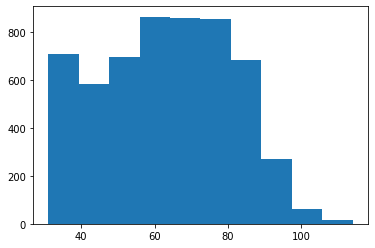

In [94]:
plt.hist(tweets['length'])
plt.show()

### Tokenize, stem, and stich back

In [119]:
nlp = spacy.load('en')

In [121]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [125]:
tweets['clean_text2'] = tweets['text'].apply(clean_text)
tweets

/Users/allenj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,user,text,gender,clean_text,length,clean_text2
0,BarackObama,"On National Gun Violence Awareness Day, we #We...",0,National Violence Awareness honor victims surv...,66,"On National Gun Violence Awareness Day, we #We..."
1,BarackObama,"Third, every city in this country should be a ...",0,Third every city this country should community...,74,"Third, every city in this country should be a ..."
2,BarackObama,"Second, every mayor should review their use of...",0,Second every mayor should review their force p...,96,"Second, every mayor should review their use of..."
3,BarackObama,"First, there are specific evidence-based refor...",0,First there specific evidence based reforms th...,96,"First, there are specific evidence-based refor..."
4,BarackObama,Real change requires protest to highlight a pr...,0,Real change requires protest highlight problem...,90,Real change requires protest to highlight a pr...
...,...,...,...,...,...,...
139,RyanLochte,"“Eyez on the Prize” made by the man, top curre...",0,Eyez Prize made currency artist transparentart...,76,"“Eyez on the Prize” made by the man, top curre..."
140,RyanLochte,Happy birthday to my lil sister @ebeisel34 you...,0,Happy birthday sister seriously bring smile ev...,57,Happy birthday to my lil sister @ebeisel34 you...
141,RyanLochte,The water is my happy place. It gives me oppor...,0,water happy place gives opportunity clear head...,58,The water is my happy place. It gives me oppor...
142,RyanLochte,The water is my happy place. It gives me oppor...,0,water happy place gives opportunity clear head...,58,The water is my happy place. It gives me oppor...


In [127]:
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [129]:
tweets['clean_text2'] = tweets['text'].apply(convert_text)

/Users/allenj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tweets

In [110]:
# Google 'pandas' .apply()


In [112]:
# Define function to capitalize all characters
def capitalize(x):
    return x.upper()

In [114]:
test = 'allen'
capitalize(test)
# do this for df column

'ALLEN'

In [ ]:
# lambda is a one use function that you don't need to define

In [ ]:
# # Tokenization
# tokenized_tweet = tweets['clean_text'].apply(lambda x: x.split())
# tokenized_tweet.head()

In [ ]:
# # Do the same for the testing dataset
# # Tokenization
# tokenized_testset = testset['clean_text'].apply(lambda x: x.split())
# tokenized_testset.head()

In [ ]:
# # Stemming
# ps = PorterStemmer()
# tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])
# tokenized_tweet.head()

In [ ]:
# # Do the same for the testing dataset
# # Stemming
# ps = PorterStemmer()
# tokenized_testset = tokenized_testset.apply(lambda x: [ps.stem(i) for i in x])
# tokenized_testset.head()

In [ ]:
# # Stich tokens back together
# for i in range(len(tokenized_tweet)):
#     tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
          
# testset['clean_text'] = tokenized_tweet
# testset['clean_text']

In [ ]:
# # Stich tokens back together
# for i in range(len(tokenized_tweet)):
#     tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
          
# testset['clean_text'] = tokenized_tweet
# testset['clean_text']

# 4. Model Selectioin and Machine Learning

### Bag of Words

In [95]:
# Bag-of-Words features
bow_vectorizer = CountVectorizer(stop_words='english')

# Bag-of-Words feature matrix
bow = bow_vectorizer.fit_transform(tweets['clean_text'])
df_bow = pd.DataFrame(bow.todense(), columns=bow_vectorizer.get_feature_names())
df_bow

,aaaah,aadar,aadhya,aaiye,aane,aankhon,aanya,aapka,aapke,aapko,...,zoom,zootopia,zordaar,zpyq,ztuwodd,zubaan,zulfi,zuri,zurich,zyaada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5591,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5592,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
# Do the same for test dataset
# Bag-of-Words feature matrix
bow = bow_vectorizer.transform(testset['clean_text'])
df_bow_test = pd.DataFrame(bow.todense(), columns=bow_vectorizer.get_feature_names())
df_bow_test

,aaaah,aadar,aadhya,aaiye,aane,aankhon,aanya,aapka,aapke,aapko,...,zoom,zootopia,zordaar,zpyq,ztuwodd,zubaan,zulfi,zuri,zurich,zyaada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Use Bag of Words to Build Model

In [97]:
# Splitting the data into training and validation set
X = df_bow
y = tweets['gender']

# Use Bag-of-Words Features
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X, y, test_size=0.2)

### Use Logistic Regression

In [98]:
# Fitting on Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_bow, y_train_bow)

LogisticRegression()

In [99]:
# The first part of the list is predicting probabilities for gender:0 (male)
# The second part of the list is predicting probabilities for gender:1 (female)
prediction_bow = logreg.predict_proba(X_test_bow)
prediction_bow

array([[0.48303119, 0.51696881],
       [0.45090773, 0.54909227],
       [0.475782  , 0.524218  ],
       ...,
       [0.10819316, 0.89180684],
       [0.80834238, 0.19165762],
       [0.71223427, 0.28776573]])

In [100]:
# Calculating the F1 score
# If prediction is greater than or equal to 0.3 than 1, else 0
# Where 0 is for male tweets and 1 is for female tweets
prediction_int = prediction_bow[:,1]>=0.5

prediction_int = prediction_int.astype(np.int)
prediction_int

# Calculating f1 score
log_bow = f1_score(y_test_bow, prediction_int)

log_bow

0.7100229533282326

### Predict with separate test dataset

In [101]:
# Check if there is a fit model
logreg.intercept_, logreg.coef_

(array([0.50585162]),
 array([[ 0.01881565, -0.10866841,  0.0470381 , ...,  0.15613033,
          0.39986485, -0.13140201]]))

In [102]:
z = df_bow_test
pred = logreg.predict_proba(z)
pred

array([[0.28103712, 0.71896288],
       [0.33476765, 0.66523235],
       [0.68951511, 0.31048489],
       [0.96750847, 0.03249153],
       [0.8242203 , 0.1757797 ],
       [0.95958759, 0.04041241]])

In [103]:
pred2 = logreg.predict(z)
pred2

array([1, 1, 0, 0, 0, 0])

In [104]:
df = pd.DataFrame(data=pred)
df

,0,1
0,0.281037,0.718963
1,0.334768,0.665232
2,0.689515,0.310485
3,0.967508,0.032492
4,0.824220,0.175780
5,0.959588,0.040412


In [105]:
pred2 = pd.DataFrame(data=pred2, columns=['predicted_gender'])
pred2

,predicted_gender
0,1
1,1
2,0
3,0
4,0
5,0


In [106]:
testset.join(pred2)

,name,gender,text,clean_text,predicted_gender
0,ArianaHuffington,1,But you have to do what you dream of doing eve...,But you have to do what you dream of doing eve...,1
1,JessicaAlba,1,My biggest baby is 11 today! I’m so proud of t...,My biggest baby is 11 today! I’m so proud of t...,1
2,Chamath,0,"Make no mistake, we may be in a terrible place...","Make no mistake, we may be in a terrible place...",0
3,BarackObama,0,"It’s World Health Day, and we owe a profound d...","It’s World Health Day, and we owe a profound d...",0
4,RichardBranson,0,"Tie-loathing adventurer, philanthropist & trou...","Tie-loathing adventurer, philanthropist & trou...",0
5,MarissaMayer,1,The highlight of my week was seeing season pas...,The highlight of my week was seeing season pas...,0


### Use TF-IDF

In [ ]:
# TF-IDF features (Term Frequency-Inverse Document Frequency)
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(tweets['clean_text'])
df_tfidf = pd.DataFrame(tfidf_matrix.todense(), columns=tfidf.get_feature_names())
df_tfidf

In [ ]:
# Do the same for the test dataset
# TF-IDF features (Term Frequency-Inverse Document Frequency)
tfidf_matrix=tfidf.transform(testset['clean_text'])
df_tfidf_test = pd.DataFrame(tfidf_matrix.todense(), columns=tfidf.get_feature_names())
df_tfidf_test

### Use TF-IDF to Build Model

In [ ]:
# Splitting the data into training and validation set
X = df_tfidf
y = tweets['gender']

# Use Bag-of-Words Features
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.2)

In [ ]:
# Using TF-IDF Features
logreg.fit(X_train_tfidf, y_train_tfidf)

In [ ]:
prediction_tfidf = logreg.predict_proba(X_test_tfidf)
prediction_tfidf

In [ ]:
# Calculating the F1 score
prediction_int = prediction_tfidf[:,1]>=0.5
prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_test_tfidf, prediction_int)
log_tfidf

### Use Decision Tree

In [ ]:
# Decision Tree
dtc = DecisionTreeClassifier(criterion='entropy', random_state=1)

In [ ]:
# Using Bag of Words as features
dtc.fit(X_train_bow, y_train_bow)
dtc_bow = dtc.predict_proba(X_test_bow)
dtc_bow

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dtc_bow = dtc_bow[:,1]>=0.5

# converting the results to integer type
dtc_int_bow=dtc_bow.astype(np.int)

# calculating f1 score
dtc_score_bow=f1_score(y_test_bow, dtc_int_bow)

dtc_score_bow

In [ ]:
# Using TF-IDF
dtc.fit(x_train_tfidf,y_train_tfidf)

In [ ]:
dtc_tfidf = dtc.predict_proba(X_test_tfidf)

dtc_tfidf

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dtc_tfidf=dtc_tfidf[:,1]>=0.3

# converting the results to integer type
dtc_int_tfidf=dtc_tfidf.astype(np.int)

# calculating f1 score
dtc_score_tfidf=f1_score(y_test_tfidf,dtc_int_tfidf)

dtc_score_tfidf

In [ ]:
# Model Comparison
Algo=['LogisticRegression(Bag-of-Words)','DecisionTree(Bag-of-Words)','LogisticRegression(TF-IDF)','DecisionTree(TF-IDF)']


In [ ]:
score = [log_bow,dct_score_bow,log_tfidf,dct_score_tfidf]

compare=pd.DataFrame({'Model':Algo,'F1_Score':score},index=[i for i in range(1,5)])
compare.T


In [ ]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare)

plt.title('Model Vs Score')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

# Test With Real Text

In [ ]:
# Check if there is a fit model

In [ ]:
Log_Reg.intercept_, Log_Reg.coef_

In [ ]:
test_text = pd.read_csv('../Data/tweetstest.csv')
test_text

In [ ]:
bow = bow_vectorizer.transform(test_text['clean_text']) #use .transform() not .fit_transform()
df_bow = pd.DataFrame(bow.todense())
df_bow

In [ ]:
prediction_bow = Log_Reg.predict_proba(X)
prediction_bow

In [ ]:
test_text = "this is a test tweet to predict my gender baby boo"

# Bag-of-Words feature matrix
bow = bow_vectorizer.fit_transform('test_text')
df_bow = pd.DataFrame(bow.todense())
df_bow

In [ ]:
text = "I am so angry"
textBlob = TextBlob(text)
print(f"{textBlob.sentiment}")

# ###### 

#### 